In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install visualkeras

     |████████████████████████████████| 992 kB 32.8 MB/s 


In [3]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 24.0 MB/s 


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import Sequential, Input
from keras.layers import Dense, Dropout, Conv2D, Flatten, SeparableConv2D, BatchNormalization, GlobalAveragePooling2D, Activation
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator as IDG

import tensorflow.keras.backend as K

import visualkeras

TRATAMENTO DE DADOS

In [5]:
base_dir = "/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Conteudo diretorios:", os.listdir(work_dir))

Conteudo diretorios: ['NonDemented', 'ModerateDemented', 'VeryMildDemented', 'MildDemented']


In [6]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [7]:
#Executando o aumento de imagem para ter mais amostras de dados
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


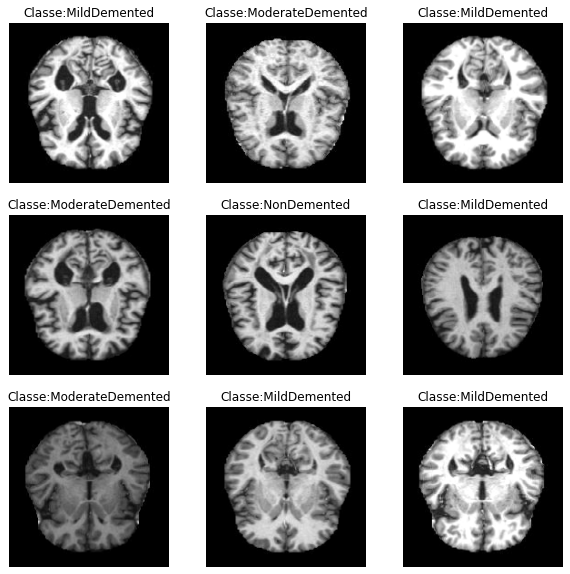

In [8]:
def show_images(generator,y_pred=None):
    
    # obter labels de imagem
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # obter um lote de imagens
    x,y = generator.next()
    
    # gera grade de 9 imagens
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Classe:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    

show_images(train_data_gen)

In [9]:
# Recuperando os dados do iterador ImageDataGenerator
train_data, train_labels = train_data_gen.next()
# Conhecendo as dimensões do nosso conjunto de dados
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [10]:
oversample = SMOTE()

train_data = train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3)

In [11]:
train_data.shape

(6400, 92928)

In [12]:
#train_data, train_labels = oversample.fit_resample(train_data, train_labels)

In [13]:
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


DIVISÃO TREINO E TESTE

In [14]:
#Dividindo os dados em conjuntos de treinamento, teste e validação

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

CONSTRUINDO MODELO

In [15]:
Mobile = MobileNetV2(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

9420800/9406464 [==============================] - 0s 0us/step


In [16]:
Mobile.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 88, 88, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 88, 88, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 88, 88, 32)   0           ['bn_Conv1[0][

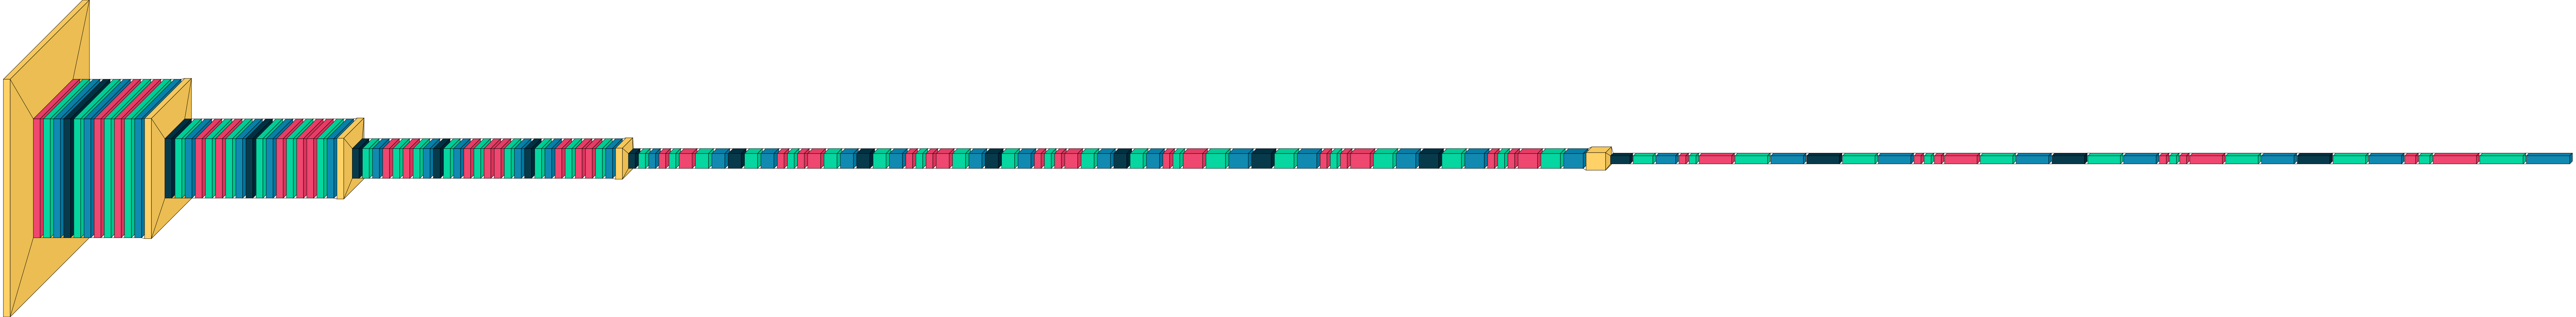

In [17]:
visualkeras.layered_view(Mobile)

In [18]:
last_output= Mobile.layers[-1].output

last_output= Flatten()(last_output)

pretrained_model= Model(Mobile.input, last_output)

In [19]:
x= Dense(units=512, activation="relu")(last_output)
x=Dropout(0.2)(x)

x= Dense(units=256, activation="relu")(last_output)
x=Dropout(0.2)(x)

x= Dense(units=128, activation="relu")(last_output)
x=Dropout(0.2)(x)

x= Dense(units=32, activation="relu")(x)
x=Dropout(0.2)(x)

x= Dense(units=16, activation="sigmoid")(x)
x=Dropout(0.2)(x)

x= Dense(units=4, activation="softmax")(x)


mobile_model= Model(pretrained_model.input, x)

mobile_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 88, 88, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 88, 88, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 88, 88, 32)   0           ['bn_Conv1[0][0]']         

In [20]:
for layer in mobile_model.layers:
    layer.trainable=False

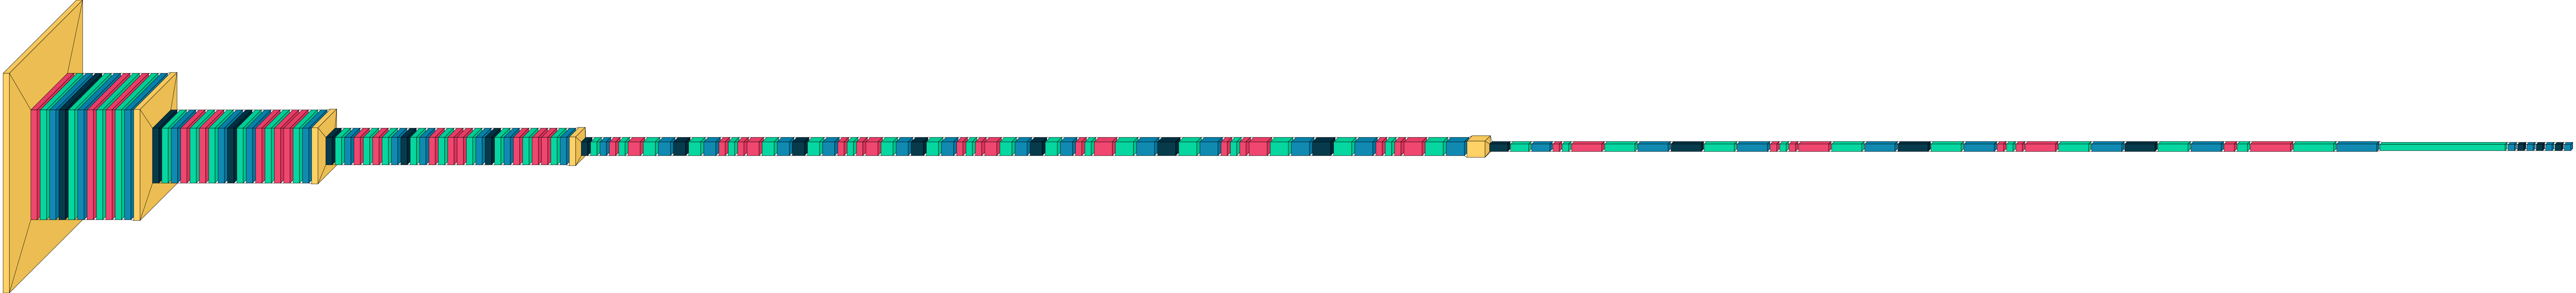

In [21]:
visualkeras.layered_view(mobile_model)

METRICAS

In [22]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [23]:
METRICS = [
            tf.keras.metrics.BinaryAccuracy(name='acuracia'),
            tf.keras.metrics.Precision(name='precisão'),
            tf.keras.metrics.Recall(name='recall'),  
            tf.keras.metrics.AUC(name='auc'),
            #tfa.metrics.F1Score(num_classes=4)
            f1_score
           ]

In [24]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.001, 5) 

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [25]:
mobile_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

In [26]:
#Fit dos dados de treinamento ao modelo e validá-lo usando os dados de validação

history = mobile_model.fit(train_data,
           train_labels,
           validation_data= (val_data, val_labels),
           epochs = 20,
           verbose = 1,
           callbacks=lr_scheduler
          )

Epoch 1/20
128/128 [==============================] - 20s 51ms/step - loss: 1.8027 - acuracia: 0.7329 - precisão: 0.1618 - recall: 0.0164 - auc: 0.4032 - f1_score: 0.0291 - val_loss: 1.7478 - val_acuracia: 0.7500 - val_precisão: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4068 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
128/128 [==============================] - 5s 38ms/step - loss: 1.8032 - acuracia: 0.7302 - precisão: 0.1447 - recall: 0.0161 - auc: 0.3998 - f1_score: 0.0282 - val_loss: 1.7478 - val_acuracia: 0.7500 - val_precisão: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4068 - val_f1_score: 0.0000e+00 - lr: 6.3096e-04
Epoch 3/20
128/128 [==============================] - 5s 38ms/step - loss: 1.7830 - acuracia: 0.7332 - precisão: 0.1638 - recall: 0.0164 - auc: 0.4102 - f1_score: 0.0289 - val_loss: 1.7478 - val_acuracia: 0.7500 - val_precisão: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4068 - val_f1_score: 0.0000e+00 - lr: 3.9811e-04
Epoch 4/20
128/128 [=====

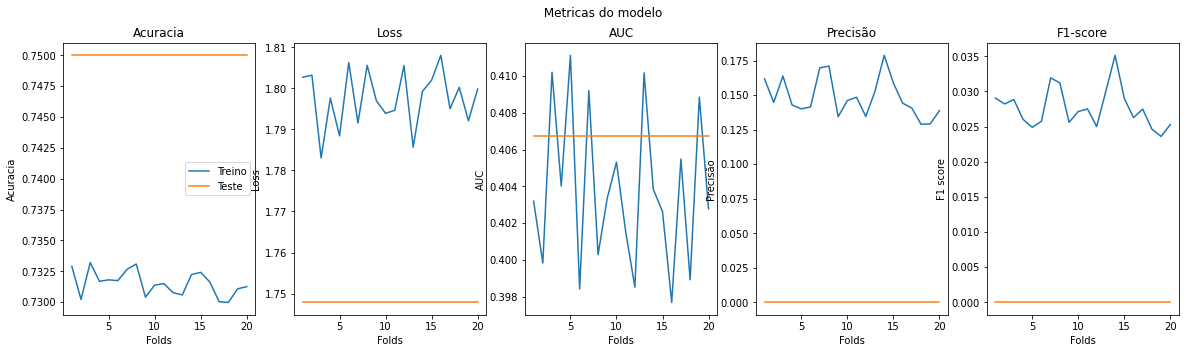

In [27]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" Metricas do modelo ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Acuracia')
    ax1.set_xlabel('Folds')
    ax1.set_ylabel('Acuracia')
    ax1.legend(['Treino', 'Teste'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Folds')
    ax2.set_ylabel('Loss')
    ax1.legend(['Treino', 'Teste'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('AUC')
    ax3.set_xlabel('Folds')
    ax3.set_ylabel('AUC')
    ax1.legend(['Treino', 'Teste'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('Precisão')
    ax4.set_xlabel('Folds')
    ax4.set_ylabel('Precisão')
    ax1.legend(['Treino', 'Teste'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('F1-score')
    ax5.set_xlabel('Folds')
    ax5.set_ylabel('F1 score')
    ax1.legend(['Treino', 'Teste'])


    plt.show()
    

Train_Val_Plot(history.history['acuracia'],history.history['val_acuracia'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precisão'],history.history['val_precisão'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [28]:
test_scores = mobile_model.evaluate(test_data, test_labels)

print("Accuracia = ", test_scores[1])
print("Precisão = ", test_scores[2])
print("Recall = ", test_scores[3])
print("AUC = ", test_scores[4])
print("F1_score = ", test_scores[5])

40/40 [==============================] - 1s 32ms/step - loss: 1.7167 - acuracia: 0.7500 - precisão: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4255 - f1_score: 0.0000e+00
Accuracia =  0.75
Precisão =  0.0
Recall =  0.0
AUC =  0.42553243041038513
F1_score =  0.0


In [29]:
pred_labels = mobile_model.predict(test_data)

In [32]:
#kpred = Mobile.predict(mobile_model)

ValueError: ignored

In [33]:
'''pred = kpred.tolist()
predictions = []
for i in pred:
  predictions.append(i.index(max(i)))'''

'pred = kpred.tolist()\npredictions = []\nfor i in pred:\n  predictions.append(i.index(max(i)))'

In [34]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [35]:
#Como os rótulos são arrays softmax, precisamos arredondar para tê-los na forma de 0s e 1s,
#semelhante aos test_labels
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.16      0.99      0.27       201
VeryMildDemented       0.00      0.00      0.00         6
    MildDemented       0.65      0.03      0.05       643
ModerateDemented       0.00      0.00      0.00       430

       micro avg       0.17      0.17      0.17      1280
       macro avg       0.20      0.25      0.08      1280
    weighted avg       0.35      0.17      0.07      1280
     samples avg       0.17      0.17      0.17      1280



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


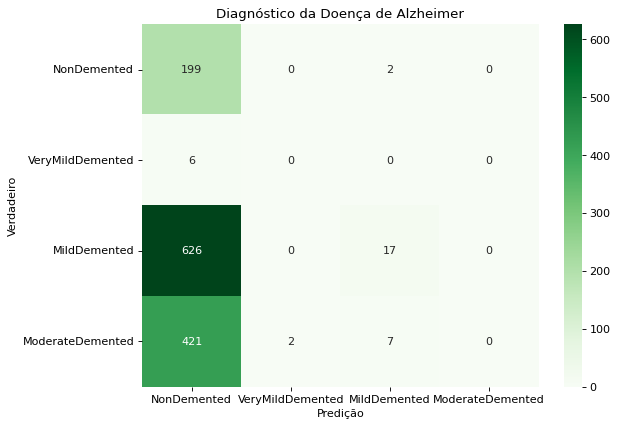

In [36]:
#Plotar a matriz de confusão para entender a classificação em detalhes

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Diagnóstico da Doença de Alzheimer')
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.show(ax)